In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk
# from read_data_with_fk import read_LHEF_data, get_fk_table

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 1

#HYPERPARAMETERS
preproc = 1

fit_level = 2
# lr = 1e-3

max_counter = 100
max_Nepochs = 3500

In [3]:
import numpy as np
import torch


def read_LHEF_data():
    """Read histograms of data

    Args:
        num_obs (int): number of files to read data from

    Returns:
        tuple: returns tuple of lists and arrays containing the data
    """

    # (binwidths, events, xvals_per_obs, max_events, min_events, xlabels) = (
    #     [],
    #     [],
    #     [],
    #     [],
    #     [],
    #     [],
    # )

    # for i in range(starting_index, num_obs):
    val_n = np.loadtxt("data/data_Enu_mu_n.dat", unpack=True)
    val_p = np.loadtxt("data/data_Enu_mu_p.dat", unpack=True)
    diff = 100
    val = 74 / 183 * val_p + (183 - 74) / 183 * val_n
    # val = np.loadtxt(f"data/data_Enu.dat", unpack=True)

    err = val/20
    binwidth = diff
    val *= binwidth

    # high_bin = np.linspace(25, 6000, 21)

    events = val
    xvals_per_obs = np.arange(0,6000,100)
    min_events = val - err
    max_events = val + err
    binwidths = binwidth

    xlabels = 'Enu'

    events_per_obs = events
    binwidths = torch.tensor(binwidths, dtype=torch.float32)

    return (
        events,
        max_events,
        min_events,
        xvals_per_obs,
        binwidths,
        xlabels,
        events_per_obs,
    )


In [4]:
import pandas as pd
import torch
import torch.nn.functional


def get_fk_table():
    """This function reads the fk table for the neutrino flux and pads them for computational efficiency later on

    Returns:
        tuple: x_alphas(grid points) and the fk table in tensor to fit torch
    """

    file_path_n = f"data/FK_Enu_mu_n.dat"
    df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
    fk_table_n = df_n.to_numpy()

    file_path_p = f"data/FK_Enu_mu_p.dat"
    df_p = pd.read_csv(file_path_p, sep="\s+", header=None)
    fk_table_p = df_p.to_numpy()

    x_alpha = fk_table_p[0, :]
    x_alpha = x_alpha.reshape(len(x_alpha), 1)

    fk_table = (74 / 183 )* fk_table_p + ((183 - 74) / 183) * fk_table_n

    # strip first row to get fk table
    fk_table = fk_table[1:, :]

    x_alpha = torch.tensor(x_alpha, dtype=torch.float32).view(-1, 1)
    fk_table = torch.tensor(fk_table, dtype=torch.float32)

    return x_alpha, fk_table


<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_68324/323372601.py:14: SyntaxWarning: invalid escape sequence '\s'
  df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_68324/323372601.py:18: SyntaxWarning: invalid escape sequence '\s'
  df_p = pd.read_csv(file_path_p, sep="\s+", header=None)


In [5]:
data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs = (
        read_LHEF_data()
    )

x_alphas, fk_tables = get_fk_table()

print(fk_tables.shape)

torch.Size([60, 50])


In [6]:
num_sum_bins = 4
data = np.sum(data.reshape(-1, num_sum_bins), axis=1)
data_min = np.sum(data_min.reshape(-1, num_sum_bins), axis=1)
data_max = np.sum(data_max.reshape(-1, num_sum_bins), axis=1)
events_per_obs = np.sum(events_per_obs.reshape(-1, num_sum_bins), axis=1)
rebin_xvals_per_obs = []
for i in range(len(data)):
    rebin_xvals_per_obs.append(xvals_per_obs[(i + 1) * num_sum_bins - 1])

print(data)
fk_tables = fk_tables.view(15, 4, 50).sum(dim=1)  # Shape: (50, 120)

print(fk_tables.shape)

[ 81.43436619 323.13440462 286.85492393 204.58305557 132.44524965
  85.17430223  59.33072403  40.82309044  28.31350808  19.45677603
  13.31252707   9.38063225   7.11712053   5.56906743   3.84909756]
torch.Size([15, 50])


In [7]:
def aggregate_entries_with_indices(threshold=20):
    rebin_data,rebin_data_max,rebin_data_min,rebin_fk_table,xvals_per_obs,rebin_events_per_obs = [],[],[],[],[],[],
    current_sum = 0
    start_idx = 0
    
    for i, value in enumerate(data):
        current_sum += value
        
        if current_sum >= threshold:
            rebin_data.append(sum(data[start_idx:i+1]))  # Sum based on indices
            rebin_data_max.append(sum(data_max[start_idx:i+1]))
            rebin_data_min.append(sum(data_min[start_idx:i+1]))
            rebin_events_per_obs.append(sum(events_per_obs[start_idx:i+1]))
            xvals_per_obs.append(rebin_xvals_per_obs[start_idx])

            summed_column = torch.sum(fk_tables[start_idx:i +1, :], axis=0)
            summed_column = summed_column.unsqueeze(0)

            rebin_fk_table.append(summed_column)
            current_sum = 0
            start_idx = i + 1
    
    # If there are remaining events that haven't been added, keep them as the last entry
    if rebin_data and current_sum > 0:
        rebin_data[-1] += sum(data[start_idx:])
        rebin_data_max[-1] += sum(data_max[start_idx:])
        rebin_data_min[-1] += sum(data_min[start_idx:])
        rebin_events_per_obs[-1] += sum(events_per_obs[start_idx:])
        rebin_fk_table[-1] += torch.sum(fk_tables[start_idx:, :], axis=0).unsqueeze(0)
    return rebin_data,rebin_data_max,rebin_data_min,rebin_fk_table, rebin_events_per_obs, xvals_per_obs

data,data_max,data_min,fk_table, events_per_obs, xvals_per_obs = aggregate_entries_with_indices(20)

fk_table = torch.cat(fk_table, dim=0)    
data = np.array(data)
data_min = np.array(data_min)
data_max = np.array(data_max)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_68324/2802658734.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


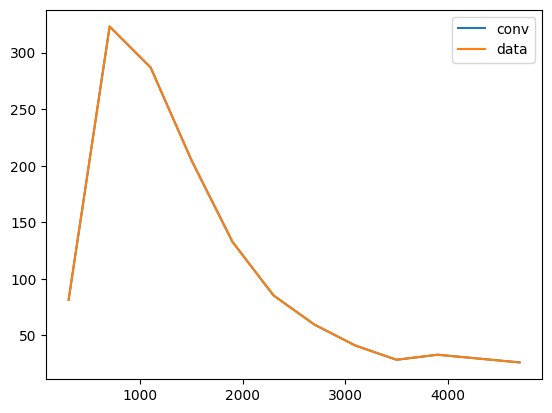

In [8]:
pdf = "faserv"
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_table,faser_pdf) * binwidths 
plt.plot(xvals_per_obs,conv,label='conv')
plt.plot(xvals_per_obs,data,label='data')
plt.legend()


In [9]:
print(data)

[ 81.43436619 323.13440462 286.85492393 204.58305557 132.44524965
  85.17430223  59.33072403  40.82309044  28.31350808  32.7693031
  25.91591777]


In [10]:

#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)    
print(min(1/sig_tot))
print(max(1/sig_tot))
print(torch.max(cov_matrix))
print(1/sig_tot)
#Generate MC replicas of data
sig_stat = np.sqrt(data)
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

#2t/m8

0.0030944375115585336
0.0385860740023876
tensor(0.0386)
[0.01227958 0.00309444 0.00348583 0.00488774 0.00755004 0.01174038
 0.01685442 0.02449569 0.03531858 0.03051611 0.03858607]
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [11]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

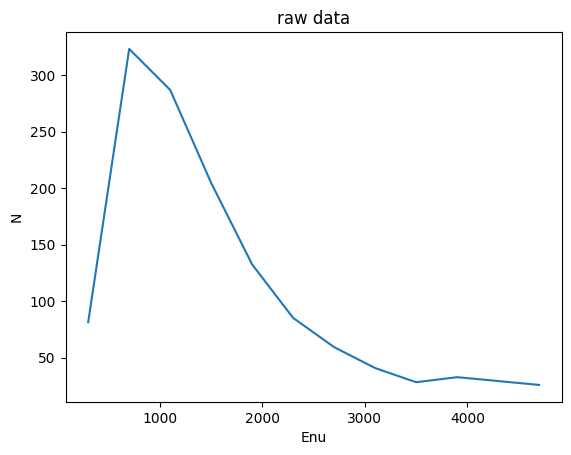

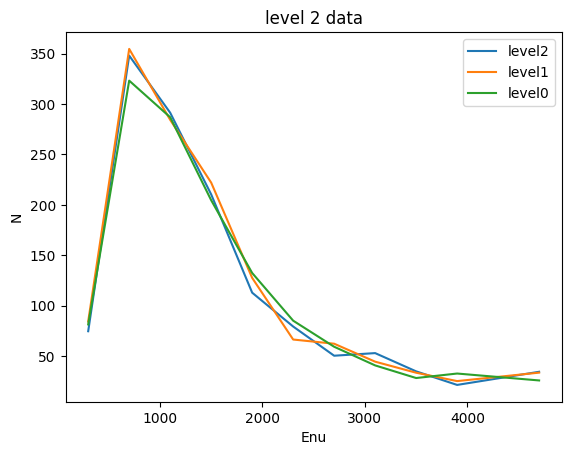

In [12]:
plt.plot(xvals_per_obs,events_per_obs)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

plt.plot(
    xvals_per_obs, level2[0], label="level2"
)
plt.plot(
    xvals_per_obs, level1[0], label="level1"
)
plt.plot(xvals_per_obs, events_per_obs,label="level0")
plt.xlabel(xlabels)
plt.legend()
plt.ylabel("N")
plt.title("level 2 data")
plt.show()


In [13]:
l1 = 3
l2 = 3
l3 = 3


class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.LeakyReLU(.1)

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [14]:
import torch.nn as nn
        
if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))
            # self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            # self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            # self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))


        def forward(self, x):
            # return self.gamma*(1 - x) ** abs(self.beta) * x ** (1-self.alpha)
            # alpha = (0.8*torch.tanh(self.alpha))
            # alpha = (1.6 - 0.2)/2 *torch.tanh(self.alpha) + (1.6 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            # return self.gamma * (1 - x) ** beta * x**(1-alpha) 
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
            # return  (1 - x) * x 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_nu
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [15]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix, small_x_point1,small_x_point2,p3
    ):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix,small_x_point1,small_x_point2,p3)
        return loss

In [16]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)

# x_vals = x_alphas
neutrino_pdfs,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[]

In [17]:
lr = 0.001

def perform_fit(pred,REPLICAS):
    if preproc == 1:
            alpha,beta,gamma = 1,1,10
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)

            criterion = CustomLoss()
            # criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.001)
            # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for i in range(REPLICAS):
        

        
        losses = []
        
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        pred[i] = pred[i].squeeze()
        # pred[i] = (pred[i] - min(pred[i]))/ (max(pred[i])-min(pred[i]))
        # pred[i] = torch.tensor(pred[i], dtype=torch.float32).view(-1,1)

        model.train()

        best_loss = 1e13 # initial loss
        counter = 0
        # num_epochs =  10000
        # for ep in range(num_epochs):
        while counter < max_counter:  
            # if num_epochs>max_Nepochs:
            #     break
            
            # num_epochs+=1
            optimizer.zero_grad()
            y_pred =  model(x_alphas)  - model(torch.tensor([.98], dtype=torch.float32).view(-1,1))
            
            # y_pred =  model(x_alphas) 
            # print(y_pred[-1])
            y_preds = torch.matmul(fk_table,y_pred)  * binwidths 
            y_preds = y_preds.squeeze()
            small_x_point1 = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1)) 
            small_x_point2 = model(torch.tensor([2*10**-3], dtype=torch.float32).view(-1,1))
            small_x_point3 = model(torch.tensor([2*10**-3], dtype=torch.float32).view(-1,1))

            loss= criterion(y_preds, pred[i],cov_matrix,small_x_point1,small_x_point2,small_x_point3)
            # loss= criterion(y_preds, pred[i])
            loss.backward()

            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         print(f"Epoch {ep}, {name}, Grad Norm: {torch.norm(param.grad).item()}")
            optimizer.step()
            losses.append(loss.item())
            print(loss)

            # if ep % 100 == 0:
            #     pass
            # print(loss.detach().numpy())   
            if loss <.001:
                break
            if loss < best_loss:
                best_loss = loss
                counter = 0
            else:
                counter +=1   

        if loss < 500:    
            # print(num_epochs) 
        
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            # print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 


            # closure_fit = Postfit()
            # arc_lenghts.append(closure_fit.compute_arc_length(model))
            # chi_squares.append(loss.detach().numpy())

            f_nu = model(x_vals).detach().numpy().flatten() 

            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals).detach().numpy().flatten())

            N_event_pred.append(y_preds.detach().numpy())
            plt.plot(xvals_per_obs,y_preds.detach().numpy().flatten(),label = 'nn')
            plt.plot(xvals_per_obs,pred[i],label = 'level2')
            plt.legend()
            plt.show()

            neutrino_pdfs.append(f_nu)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
            print(f'small_x_point = {small_x_point1}')
            print(f'small_x_point = {small_x_point2}')
    print(pred[i]-y_preds)
    print('model') 
    print(model(torch.tensor([.98], dtype=torch.float32).view(-1,1)) )
    return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model

tensor(1330.9131, grad_fn=<AddBackward0>)
tensor(1330.7087, grad_fn=<AddBackward0>)
tensor(1330.5037, grad_fn=<AddBackward0>)
tensor(1330.2980, grad_fn=<AddBackward0>)
tensor(1330.0911, grad_fn=<AddBackward0>)
tensor(1329.8835, grad_fn=<AddBackward0>)
tensor(1329.6753, grad_fn=<AddBackward0>)
tensor(1329.4658, grad_fn=<AddBackward0>)
tensor(1329.2556, grad_fn=<AddBackward0>)
tensor(1329.0444, grad_fn=<AddBackward0>)
tensor(1328.8323, grad_fn=<AddBackward0>)
tensor(1328.6194, grad_fn=<AddBackward0>)
tensor(1328.4054, grad_fn=<AddBackward0>)
tensor(1328.1903, grad_fn=<AddBackward0>)
tensor(1327.9744, grad_fn=<AddBackward0>)
tensor(1327.7573, grad_fn=<AddBackward0>)
tensor(1327.5392, grad_fn=<AddBackward0>)
tensor(1327.3201, grad_fn=<AddBackward0>)
tensor(1327.1000, grad_fn=<AddBackward0>)
tensor(1326.8787, grad_fn=<AddBackward0>)
tensor(1326.6562, grad_fn=<AddBackward0>)
tensor(1326.4327, grad_fn=<AddBackward0>)
tensor(1326.2080, grad_fn=<AddBackward0>)
tensor(1325.9822, grad_fn=<AddBack

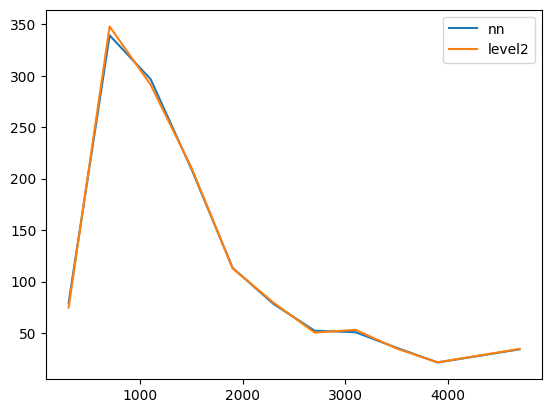

counter = 100


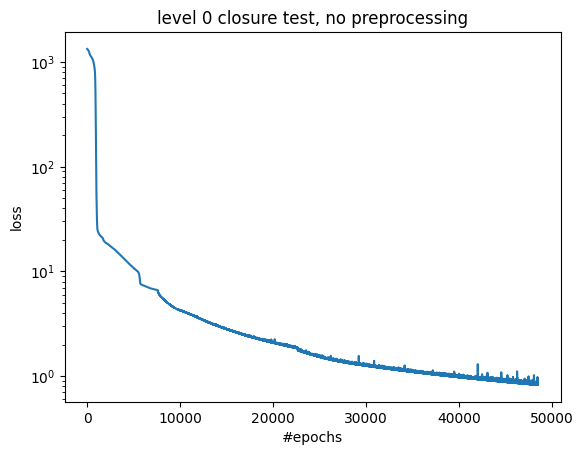

small_x_point = tensor([[2470529.]], grad_fn=<MulBackward0>)
small_x_point = tensor([[503026.3125]], grad_fn=<MulBackward0>)
tensor([-4.6824,  8.6259, -5.3849,  1.3217, -0.3278,  1.1932, -1.7592,  2.3056,
        -0.6892,  0.1588,  0.4145], grad_fn=<SubBackward0>)
model
tensor([[473.4440]], grad_fn=<MulBackward0>)


In [18]:
arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(pred,REPLICAS)

In [19]:
print(cov_matrix)
# closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred,neutrino_pdfs)

tensor([[0.0123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0031, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0035, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0049, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0076, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0117, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0169, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0245, 0.0000,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0353,
         0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.00

In [20]:
# x_vals = x_vals.detach().numpy().flatten()
x_vals = x_vals.detach().numpy().flatten()
faser_pdf,x_faser = read_pdf(pdf,x_vals,14) 
mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [21]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

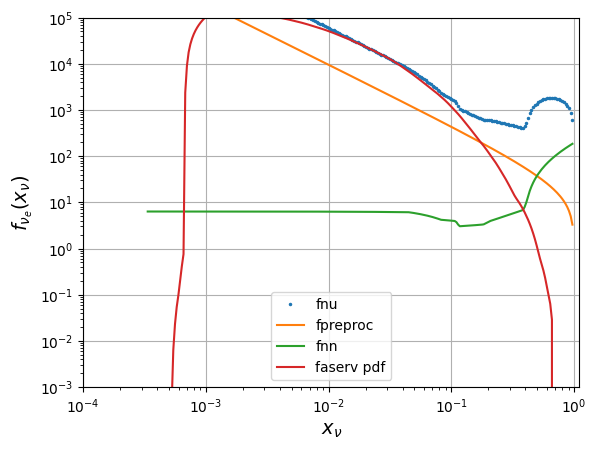

In [22]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu/x_vals,'o',label="fnu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**5)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

In [23]:
print(level0)

[tensor([ 81.4344, 323.1344, 286.8549, 204.5831, 132.4453,  85.1743,  59.3307,
         40.8231,  28.3135,  32.7693,  25.9159])]


In [24]:
print(xvals_per_obs)

[300, 700, 1100, 1500, 1900, 2300, 2700, 3100, 3500, 3900, 4700]


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
[ 81.434364 323.1344   286.85492  204.58305  132.44525   85.1743
  59.330723  40.82309   28.313509  32.769302  25.915918  25.915918]
[ 79.38607  339.32776  296.7104   209.03574  113.25262   78.188995
  52.1879    50.71689   35.604652  21.319416  34.09394   34.09394 ]
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:82: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:83: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu - error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:84: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu + error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:188: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


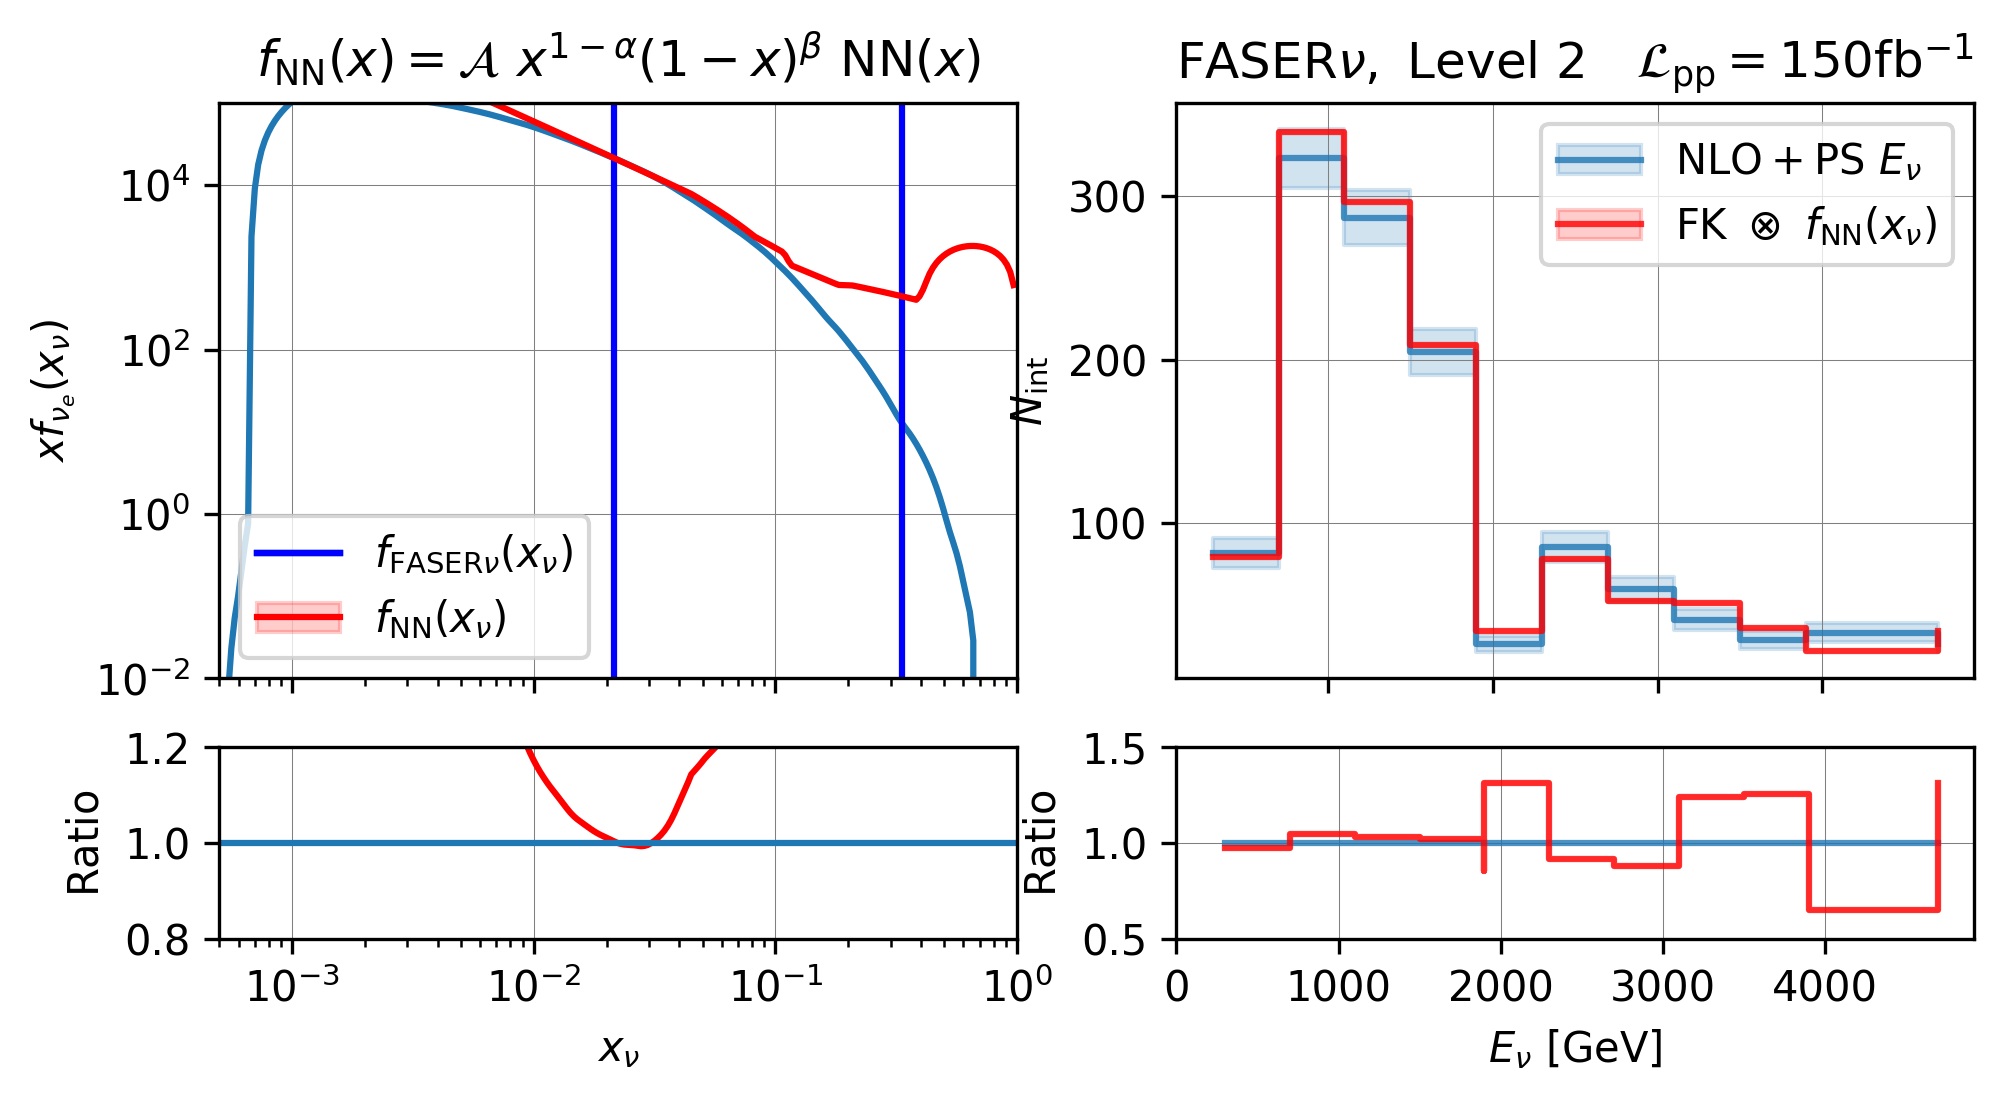

In [25]:
from plot_results import plot
sig_tot = np.sqrt(sig_tot)
plot(x_vals, neutrino_pdfs, level0, N_event_pred, sig_tot, xvals_per_obs,14)

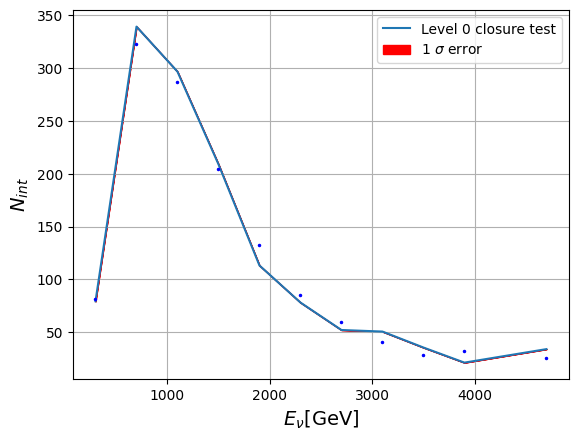

In [26]:
mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
plt.plot(xvals_per_obs,mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(xvals_per_obs,(mean_N_event_fit+sigma_N_event_fit),(mean_N_event_fit-sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(xvals_per_obs,level0[0],'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [27]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
# x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo